# London Modelling

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
import seaborn as sns
from scipy.stats import gaussian_kde
import contextily as ctx
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%config InlineBackend.figure_format = 'retina'
from mgwr.gwr import GWR
from mgwr.sel_bw import Sel_BW
import matplotlib.font_manager as fm
import xgboost as xgb
import shap

## 1. Import Data

In [2]:
# Import data
london_airbnb = gpd.read_file('../../data/london/airbnb_per_london_glx.gpkg')
london_tourism_fs = gpd.read_file('../../data/london/london_glx_tourism_pois.gpkg')

In [3]:
# Merge the two datasets on glx_id keeping only one geometry column
london_airbnb_tourism_fs = london_tourism_fs.merge(london_airbnb, on='glx_id', how='left')

# Drop geometry_x and rename geometry_y to geometry
london_airbnb_tourism_fs.drop(columns=['geometry_x'], inplace=True)
london_airbnb_tourism_fs.rename(columns={'geometry_y': 'geometry'}, inplace=True)

In [4]:
london_airbnb_tourism_fs.columns

Index(['glx_id', 'Airport/Heliport', 'Bakery/Patisserie', 'Bar (General)',
       'Beach', 'Beer Bar/Garden', 'Bike Rental', 'Brewery/Distillery',
       'Bridge', 'Bus Stop',
       ...
       'density_m2', 'density_km2', 'num_properties_log', 'density_m2_log',
       'density_km2_log', 'total_revenue_log', 'total_volume_log',
       'total_tourism_intensity_km2', 'total_tourism_intensity_km2_log',
       'geometry'],
      dtype='object', length=226)

## 2. Data Exploration

In [5]:
# Create total_pois_log column
london_airbnb_tourism_fs['total_pois_log'] = np.log1p(london_airbnb_tourism_fs['total_pois'])

Text(0, 0.5, 'Tourism Intensity (km²)')

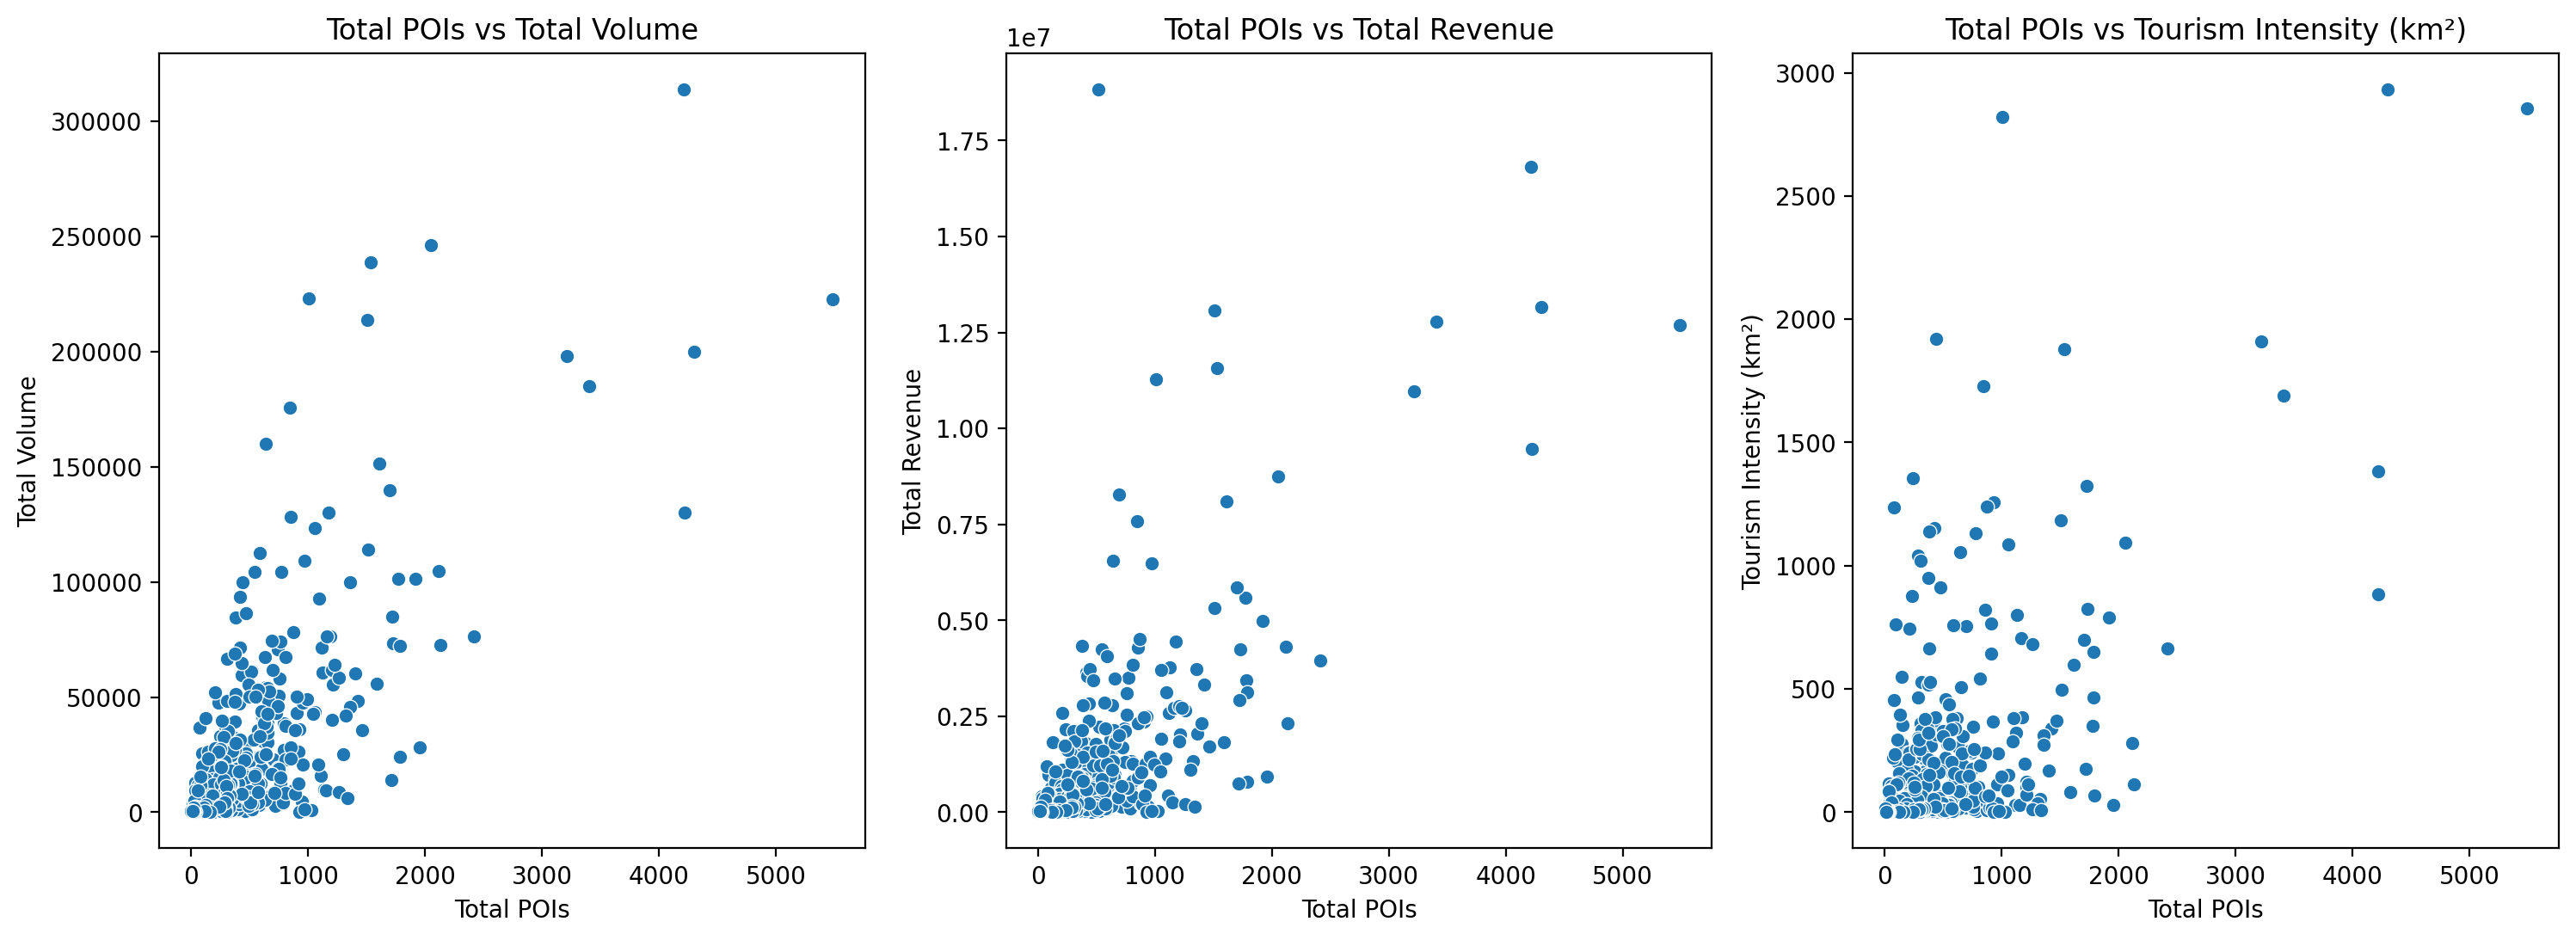

In [6]:
# Create three scatter plots showing total_pois vs, total_volume, total_revenue, and total_tourism_intensity_km2
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
sns.scatterplot(data=london_airbnb_tourism_fs, x='total_pois', y='total_volume', ax=axes[0])
axes[0].set_title('Total POIs vs Total Volume')
axes[0].set_xlabel('Total POIs')
axes[0].set_ylabel('Total Volume')
sns.scatterplot(data=london_airbnb_tourism_fs, x='total_pois', y='total_revenue', ax=axes[1])
axes[1].set_title('Total POIs vs Total Revenue')
axes[1].set_xlabel('Total POIs')
axes[1].set_ylabel('Total Revenue')
sns.scatterplot(data=london_airbnb_tourism_fs, x='total_pois', y='total_tourism_intensity_km2', ax=axes[2])
axes[2].set_title('Total POIs vs Tourism Intensity (km²)')
axes[2].set_xlabel('Total POIs')
axes[2].set_ylabel('Tourism Intensity (km²)')

In [7]:
# Find the number of rows that have 0 values in total_volume, total_revenue, and total_tourism_intensity_km2
zero_volume = london_airbnb_tourism_fs[london_airbnb_tourism_fs['total_volume'] == 0].shape[0]
zero_revenue = london_airbnb_tourism_fs[london_airbnb_tourism_fs['total_revenue'] == 0].shape[0]
zero_tourism_intensity = london_airbnb_tourism_fs[london_airbnb_tourism_fs['total_tourism_intensity_km2'] == 0].shape[0]
print(f"Rows with zero total_volume: {zero_volume}")
print(f"Rows with zero total_revenue: {zero_revenue}")
print(f"Rows with zero total_tourism_intensity_km2: {zero_tourism_intensity}")

Rows with zero total_volume: 12
Rows with zero total_revenue: 12
Rows with zero total_tourism_intensity_km2: 12


In [8]:
# For rows with zero values replace with NaN
london_airbnb_tourism_fs['total_volume'] = london_airbnb_tourism_fs['total_volume'].replace(0, np.nan)
london_airbnb_tourism_fs['total_revenue'] = london_airbnb_tourism_fs['total_revenue'].replace(0, np.nan)
london_airbnb_tourism_fs['total_tourism_intensity_km2'] = london_airbnb_tourism_fs['total_tourism_intensity_km2'].replace(0, np.nan)

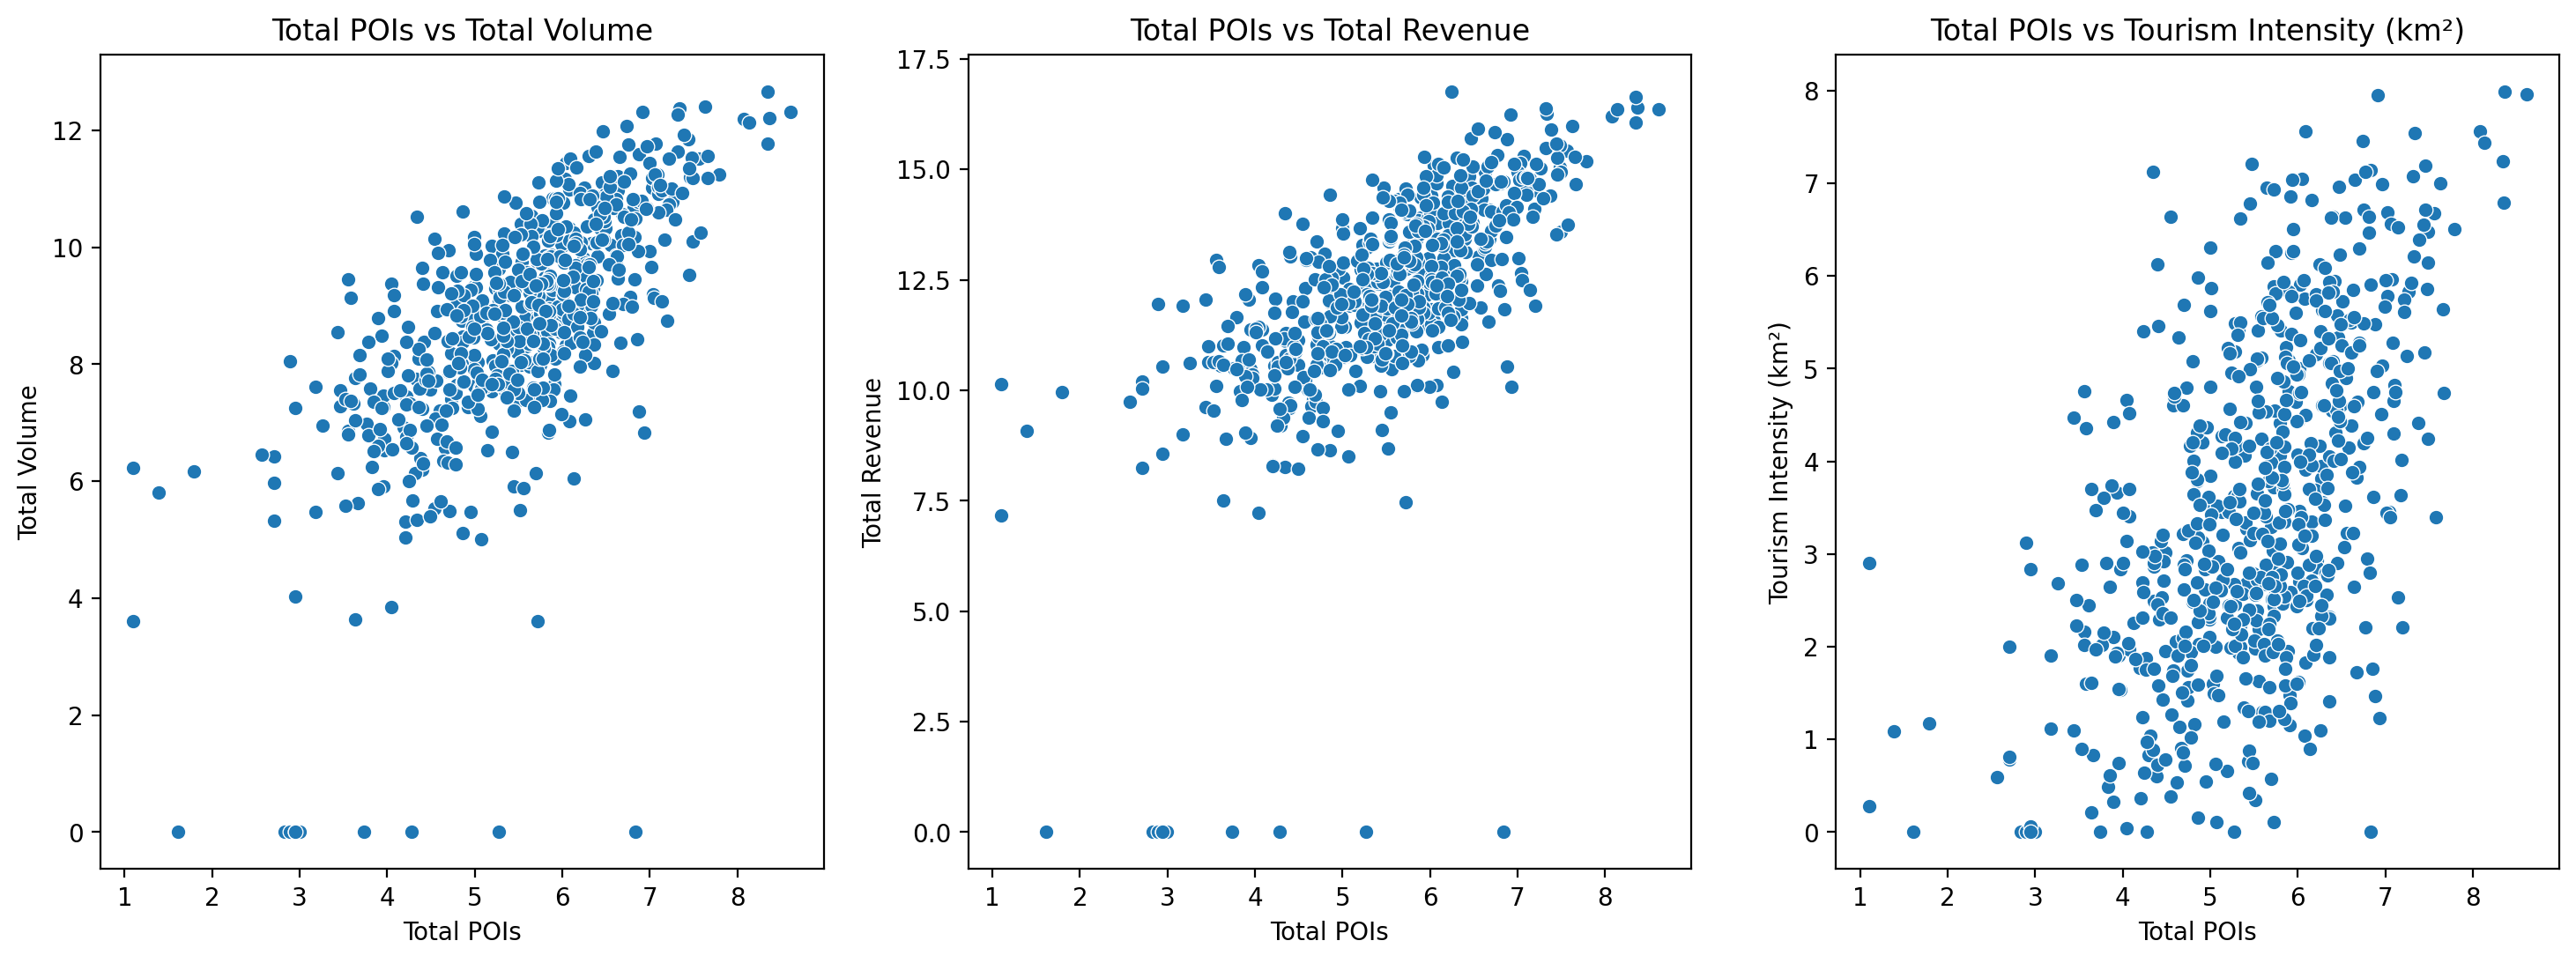

In [9]:
# Create three scatter plots showing total_pois vs, total_volume, total_revenue, and total_tourism_intensity_km2
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
sns.scatterplot(data=london_airbnb_tourism_fs, x='total_pois_log', y='total_volume_log', ax=axes[0])
axes[0].set_title('Total POIs vs Total Volume')
axes[0].set_xlabel('Total POIs')
axes[0].set_ylabel('Total Volume')
sns.scatterplot(data=london_airbnb_tourism_fs, x='total_pois_log', y='total_revenue_log', ax=axes[1])
axes[1].set_title('Total POIs vs Total Revenue')
axes[1].set_xlabel('Total POIs')
axes[1].set_ylabel('Total Revenue')
sns.scatterplot(data=london_airbnb_tourism_fs, x='total_pois_log', y='total_tourism_intensity_km2_log', ax=axes[2])
axes[2].set_title('Total POIs vs Tourism Intensity (km²)')
axes[2].set_xlabel('Total POIs')
axes[2].set_ylabel('Tourism Intensity (km²)');

In [17]:
# Show the head of the london_airbnb_tourism_fs DataFrame asscending by total_volume, only show the volume column
print(london_airbnb_tourism_fs[['glx_id', 'total_revenue']].sort_values(by='total_revenue', ascending=False).head())

         glx_id  total_revenue
313  2120006018     18821813.0
344  2120006049     16811887.0
151  2120005850     13162336.0
480  2120006186     13071857.0
461  2120006167     12791218.0
